BraTS Challenge Demo-Notebook

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from data_loading import BraTS_Dataset
from dataset_utils import split_cube, split_cube_with_context, slice_cube, segment_entire_3d_cube
from dataset_utils import plot_batch, plot_minicube_pred_label, plot_cube_pred_label, plot_loss
from data_loading import get_train_test_iters
torch.manual_seed(42)
from Architectures.unet_3d import UNet3D
from Architectures.unet_2d import UNet2D
from train import train_model
from custom_losses import get_loss, DiceLoss

Data Loading

In [2]:
batch_size = 1
train_iter, test_iter = get_train_test_iters('../Task01_BrainTumour/cropped', batch_size=batch_size, shuffle=True, num_workers=0)

../Task01_BrainTumour/cropped/imagesTr
../Task01_BrainTumour/cropped/labelsTr
../Task01_BrainTumour/cropped/imagesTs
../Task01_BrainTumour/cropped/labelsTs


In [3]:
batch = split_cube(train_iter.next())
batch['image'].shape

torch.Size([8, 4, 80, 96, 96])

Create the model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1060 3GB


Training Loop

In [5]:
# hyperparameters
train_3d = True
compute_test_loss = True
epochs = 5
batches_per_epoch = 1
learning_rate = 0.1

# init model
if train_3d:
    model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    model = UNet2D().to(device)

# init optimizer and loss_fn
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = DiceLoss()

print(f'training {model.__class__.__name__}:')
train_losses, test_losses = train_model(model, optim, loss_fn, epochs, device, train_3d, 
                                        train_iter, test_iter, compute_test_loss, batches_per_epoch)

training UNet3D:
epoch 0: epoch_train_loss=0.793, epoch_test_loss=0.750
epoch 1: epoch_train_loss=0.751, epoch_test_loss=0.740
epoch 2: epoch_train_loss=0.739, epoch_test_loss=0.739
epoch 3: epoch_train_loss=0.748, epoch_test_loss=0.744
epoch 4: epoch_train_loss=0.735, epoch_test_loss=0.744


Plot losses

Loss curve using DiceLoss():


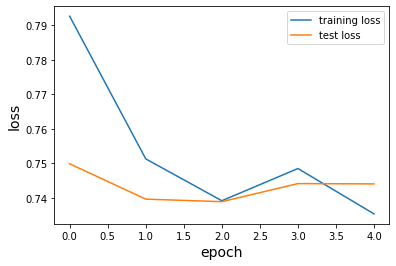

In [6]:
print(f'Loss curve using {loss_fn}:')
plot_loss(train_losses, test_losses, loss_fn)

Load inference model

In [7]:
weights_filename = 'UNet3D_epoch7_step7_loss0.738.h5'
inference_model = UNet3D(num_modalities=4, num_classes=4, img_height=96, img_width=96).to(device)
inference_model.load_state_dict(torch.load('../Weights/' + weights_filename))
inference_model.eval();

Predict

Input:


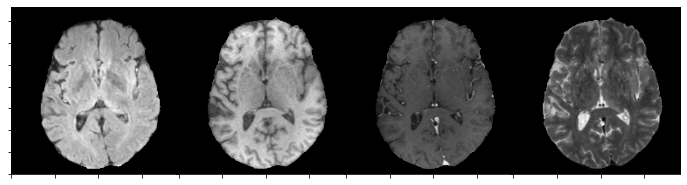

Output:


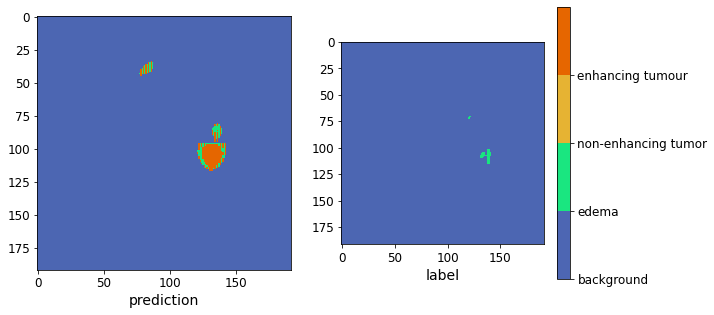

In [8]:
height = 70

print('Input:')
batch = train_iter.next()
plot_batch(batch, num_rows=batch_size, height=height)

print('Output:')
if train_3d:   
    # predict entire cube
    plot_cube_pred_label(inference_model, batch, device, height=height)
    # segmented_cube = segment_entire_3d_cube(inference_model, batch, device)
    
else:
    batch = slice_cube(raw_batch) # Get batch of 2D slices
    # TODO: plot prediction and label for 2D